In [2]:
!pip install wfdb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 KB 7.5 MB/s eta 0:00:00
  Attempting uninstall: SoundFile
    Found existing installation: soundfile 0.12.1
    Uninstalling soundfile-0.12.1:
      Successfully uninstalled soundfile-0.12.1


In [3]:
from zipfile import ZipFile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
import wfdb
from statistics import mean
import plotly.express as px

# Analysis and preparation of the dataset

In [4]:
temp='mit-bih-arrhythmia-database-1.0.0.zip' 
f = ZipFile(temp)  
f.extractall() 
f.close()

In [5]:
data_path = 'mit-bih-arrhythmia-database-1.0.0/'

In [6]:
pts = ['100','101','102','103','104','105','106','107',
       '108','109','111','112','113','114','115','116',
       '117','118','119','121','122','123','124','200',
       '201','202','203','205','207','208','209','210',
       '212','213','214','215','217','219','220','221',
       '222','223','228','230','231','232','233','234']

## Distribution of heart beat types accross all files

In [7]:
#Anotation dataframe

df = pd.DataFrame()

for pt in pts:
    file = data_path + pt
    annotation = wfdb.rdann(file, 'atr')
    sym = annotation.symbol
    
    values, counts = np.unique(sym, return_counts=True)
    df_sub = pd.DataFrame({'sym':values, 'val':counts, 'pt':[pt]*len(counts)})
    df = pd.concat([df, df_sub],axis = 0)

In [8]:
df.head(20)

,sym,val,pt
0,+,1,100
1,A,33,100
2,N,2239,100
3,V,1,100
0,+,1,101
1,A,3,101
2,N,1860,101
3,Q,2,101
4,|,4,101
5,~,4,101


In [9]:
df.groupby('sym').val.sum().sort_values(ascending = False)

sym
N    75052
L     8075
R     7259
V     7130
/     7028
A     2546
+     1291
f      982
F      803
~      616
!      472
"      437
j      229
x      193
a      150
|      132
E      106
J       83
Q       33
e       16
[        6
]        6
S        2
Name: val, dtype: int64

In [10]:
# list of nonbeat and abnormal
nonbeat = ['[','!',']','x','(',')','p','t','u','`',
           '\'','^','|','~','+','s','T','*','D','=','"','@','Q','?']
abnormal = ['L','R','V','/','A','f','F','j','a','E','J','e','S']

In [11]:
df['cat'] = -1
df.loc[df.sym == 'N','cat'] = 0
df.loc[df.sym.isin(abnormal), 'cat'] = 1

In [12]:
df.head()

,sym,val,pt,cat
0,+,1,100,-1
1,A,33,100,1
2,N,2239,100,0
3,V,1,100,1
0,+,1,101,-1


In [13]:
df.groupby('cat').val.sum()

cat
-1     3186
 0    75052
 1    34409
Name: val, dtype: int64

In [14]:
fig = px.pie(df,values=df.groupby('cat').val.sum(),
             names=df['cat'].value_counts().index,
             title="Distribution of symbol types",)
fig.show()

## Abnormal heartbeat visualisation

In [15]:
def load_ecg(file):
    # load the ecg
    # example file: 'mit-bih-arrhythmia-database-1.0.0/101'
    
    # load the ecg
    record = wfdb.rdrecord(file)
    # load the annotation
    annotation = wfdb.rdann(file, 'atr')
    
    # extract the signal
    p_signal = record.p_signal
    
    # verify frequency is 360
    assert record.fs == 360, 'sample freq is not 360'
    
    # extract symbols and annotation index
    atr_sym = annotation.symbol
    atr_sample = annotation.sample
    
    return p_signal, atr_sym, atr_sample

In [16]:
file = data_path + pts[0]

In [17]:
p_signal, atr_sym, atr_sample = load_ecg(file)

In [18]:
values, counts = np.unique(sym, return_counts=True)
for v,c in zip(values, counts):
    print(v,c)

+ 3
J 50
N 2700
V 3
~ 8


In [19]:
# get abnormal beat index
ab_index = [b for a,b in zip(atr_sym,atr_sample) if a in abnormal][:10]
ab_index

[2044, 66792, 74986, 99579, 128085, 170719, 279576, 305709, 307745, 312825]

In [20]:
x = np.arange(len(p_signal))

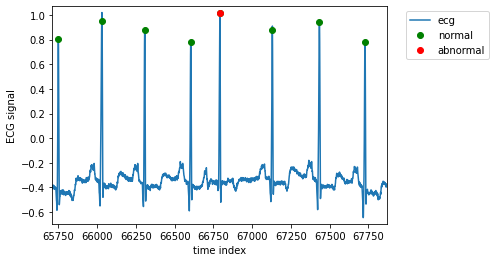

In [21]:
left = ab_index[1]-1080
right = ab_index[1]+1080

plt.plot(x[left:right],p_signal[left:right,0],'-',label='ecg',)
plt.plot(x[atr_sample],p_signal[atr_sample,0],'go',label ='normal')
plt.plot(x[ab_index],p_signal[ab_index,0],'ro',label='abnormal')

plt.xlim(left,right)
plt.ylim(p_signal[left:right].min()-0.05,p_signal[left:right,0].max()+0.05)
plt.xlabel('time index')
plt.ylabel('ECG signal')
plt.legend(bbox_to_anchor = (1.04,1), loc = 'upper left')
plt.show()

## Patient ECG Analysis

In [22]:
file = data_path + pts[0]
p_signal, atr_sym, atr_sample = load_ecg(file)
print(type(p_signal))
print(p_signal[:,0])
print(type(atr_sym))
print(atr_sym)
print(type(atr_sample))
print(atr_sample)

<class 'numpy.ndarray'>
[-0.145 -0.145 -0.145 ... -0.675 -0.765 -1.28 ]
<class 'list'>
['+', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'A', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N

In [23]:
mean_signal = []
isAbnormal = []
for pt in pts:
        file = data_path + pt
        p_signal, atr_sym, atr_sample = load_ecg(file)
        mean_signal.append(mean(p_signal[:,0]))
        ab_index = [b for a,b in zip(atr_sym,atr_sample) if a in abnormal]
        if len(ab_index) != 0:
          isAbnormal.append(True)
        else:
          isAbnormal.append(False)
print(mean_signal)

df_patients = pd.DataFrame({'patient':pts,
                       'mean_signal':mean_signal,
                       'isAbnormal':isAbnormal})

[-0.30629897692307695, -0.28422196923076926, -0.24585376923076924, -0.2314303923076923, -0.22507546923076924, -0.22515476153846153, -0.17783184615384615, -0.2326442, -0.22867901538461538, -0.23032500769230768, -0.16380573846153845, -0.8223962769230769, -0.15514067692307693, -0.1554834076923077, -0.4881058615384615, -0.9363103461538461, -0.8518542615384616, -0.8580768230769231, -0.8611456076923076, -0.8097007923076923, -0.8436382846153846, -0.7964646769230769, -0.8081609153846154, -0.105389, -0.15993703846153845, -0.16923303076923077, -0.1694699153846154, -0.3057188769230769, -0.17093456923076922, -0.1654162923076923, -0.16468404615384616, -0.15675947692307693, -0.15616623076923078, -0.22087296923076924, -0.1611474, -0.1519386153846154, -0.16514164615384616, -0.5867740692307692, -0.5404387923076923, -0.16401040769230768, -0.1565349, -0.5114729538461539, -0.13842795384615383, -0.16996823846153847, -0.15817635384615383, -0.1513895076923077, -0.1537215923076923, -0.16079954615384615]


In [24]:
df_patients.head(5)

,patient,mean_signal,isAbnormal
0,100,-0.306299,True
1,101,-0.284222,True
2,102,-0.245854,True
3,103,-0.231430,True
4,104,-0.225075,True


In [25]:
fig = px.pie(df_patients,values=df_patients['isAbnormal'].value_counts().values,
             names=df_patients['isAbnormal'].value_counts().index,
             title="Distribution of normal and abnormal signal",)
fig.show()

#Comparision of the LSTM model and SOM + HMM model

## Train and valid data creation

In [26]:
def make_dataset(pts, num_sec, fs, abnormal):
    # function for making dataset ignoring non-beats
    # input:
    # pts - list of patients
    # num_sec = number of seconds to include before and after the beat
    # fs = frequency
    # output: 
    #   X_all = signal (nbeats , num_sec * fs columns)
    #   Y_all = binary is abnormal (nbeats, 1)
    #   sym_all = beat annotation symbol (nbeats,1)
    
    # initialize numpy arrays
    num_cols = 2*num_sec * fs
    X_all = np.zeros((1,num_cols))
    Y_all = np.zeros((1,1))
    sym_all = []
    
    # list to keep track of number of beats across patients
    max_rows = []
    
    for pt in pts:
        file = data_path + pt
        
        p_signal, atr_sym, atr_sample = load_ecg(file)
        
        # grab the first signal
        p_signal = p_signal[:,0]
        
        # make df to exclude the nonbeats
        df_ann = pd.DataFrame({'atr_sym':atr_sym,
                              'atr_sample':atr_sample})
        df_ann = df_ann.loc[df_ann.atr_sym.isin(abnormal + ['N'])]
        
        X,Y,sym = build_XY(p_signal,df_ann, num_cols, abnormal)
        sym_all = sym_all+sym
        max_rows.append(X.shape[0])
        X_all = np.append(X_all,X,axis = 0)
        Y_all = np.append(Y_all,Y,axis = 0)
    # drop the first zero row
    X_all = X_all[1:,:]
    Y_all = Y_all[1:,:]
    
    # check sizes make sense
    assert np.sum(max_rows) == X_all.shape[0], 'number of X, max_rows rows messed up'
    assert Y_all.shape[0] == X_all.shape[0], 'number of X, Y rows messed up'
    assert Y_all.shape[0] == len(sym_all), 'number of Y, sym rows messed up'

    return X_all, Y_all, sym_all



def build_XY(p_signal, df_ann, num_cols, abnormal):
    # this function builds the X,Y matrices for each beat
    # it also returns the original symbols for Y
    
    num_rows = len(df_ann)

    X = np.zeros((num_rows, num_cols))
    Y = np.zeros((num_rows,1))
    sym = []
    
    # keep track of rows
    max_row = 0

    for atr_sample, atr_sym in zip(df_ann.atr_sample.values,df_ann.atr_sym.values):

        left = max([0,(atr_sample - num_sec*fs) ])
        right = min([len(p_signal),(atr_sample + num_sec*fs) ])
        x = p_signal[left: right]
        if len(x) == num_cols:
            X[max_row,:] = x
            Y[max_row,:] = int(atr_sym in abnormal)
            sym.append(atr_sym)
            max_row += 1
    X = X[:max_row,:]
    Y = Y[:max_row,:]
    return X,Y,sym

In [28]:
num_sec = 3
fs = 360

In [29]:
import random
random.seed(42)
pts_train = random.sample(pts, 36)
pts_valid = [pt for pt in pts if pt not in pts_train]
print(len(pts_train),len(pts_valid))

36 12


In [30]:
X_train, y_train, sym_train = make_dataset(pts_train, num_sec, fs, abnormal)
X_valid, y_valid, sym_valid = make_dataset(pts_valid, num_sec, fs, abnormal)
print(X_train.shape, y_train.shape, len(sym_train))
print(X_valid.shape, y_valid.shape, len(sym_valid))

(80614, 2160) (80614, 1) 80614
(28485, 2160) (28485, 1) 28485


In [31]:
# reshape input to be [samples, time steps, features = 1]
X_train_cnn = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_valid_cnn = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))
print(X_train_cnn.shape)
print(X_valid_cnn.shape)

(80614, 2160, 1)
(28485, 2160, 1)


## LSTM model

In [67]:
from keras.layers import Bidirectional, LSTM
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Dropout
from keras.utils import to_categorical

In [36]:
#model = Sequential()
#model.add(Bidirectional(LSTM(64, input_shape=(X_train_cnn.shape[1], X_train_cnn.shape[2]))))
#model.add(Dropout(rate = 0.25))
#model.add(Dense(1, activation = 'sigmoid'))
#model.compile(
#                loss = 'binary_crossentropy',
#                optimizer = 'adam',
#                metrics = ['accuracy'])

In [37]:
#model.fit(X_train_cnn[:10000], y_train[:10000], batch_size = 32, epochs= 1, verbose = 1)

313/313 [==============================] - 500s 2s/step - loss: 0.5403 - accuracy: 0.7371


In [38]:
#model.save("model/lstm.h5")

In [68]:
lstm_model = load_model("model/lstm.h5")

In [69]:
y_train_preds_lstm = lstm_model.predict(X_train_cnn[:10000],verbose = 1)
y_valid_preds_lstm = lstm_model.predict(X_valid_cnn,verbose = 1)

891/891 [==============================] - 400s 449ms/step


In [70]:
thresh = (sum(y_train)/len(y_train))[0]
thresh

0.29906715955045027

## SOM + HMM model

In [42]:
!pip install sklearn-som

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [71]:
from sklearn_som.som import SOM
import pickle

In [72]:
#ecg_som = SOM(m=2, n=1, dim=2160)
#transform_data_train = ecg_som.fit_transform(X_train[:10000])
#with open("model/som.pkl", 'wb') as file:
#   pickle.dump(ecg_som,file)

In [73]:
with open("model/som.pkl", 'rb') as file:
   egc_som = pickle.load(file)
transform_data_train = ecg_som.transform(X_train[:10000])
transform_data_valid = ecg_som.transform(X_valid)

In [50]:
!pip install hmmlearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 217.1/217.1 KB 3.0 MB/s eta 0:00:00


In [74]:
from hmmlearn import hmm

In [53]:
#hmm_model = hmm.GaussianHMM(n_components=2)
#hmm_model.fit(transform_data_train)
#with open("model/hmm.pkl", 'wb') as file:
#   pickle.dump(hmm_model,file)

In [75]:
with open("model/hmm.pkl", 'rb') as file:
   hmm_model = pickle.load(file)
y_train_preds_SHMM = hmm_model.predict(transform_data_train)
y_valid_preds_SHMM = hmm_model.predict(transform_data_valid)

In [76]:
trans_y_train_preds_SHMM = y_train_preds_SHMM.reshape(-1,1)
print(trans_y_train_preds_SHMM)
trans_y_valid_preds_SHMM = y_valid_preds_SHMM.reshape(-1,1)
print(trans_y_train_preds_SHMM)

[[0]
 [0]
 [0]
 ...
 [1]
 [1]
 [1]]
[[0]
 [0]
 [0]
 ...
 [1]
 [1]
 [1]]


# Results presentation

## Metrics display

In [77]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
def calc_prevalence(y_actual):
    return (sum(y_actual)/len(y_actual))
def calc_specificity(y_actual, y_pred, thresh):
    # calculates specificity
    return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)
def print_report(y_actual, y_pred, thresh):
    
    auc = roc_auc_score(y_actual, y_pred)
    accuracy = accuracy_score(y_actual, (y_pred > thresh))
    recall = recall_score(y_actual, (y_pred > thresh))
    precision = precision_score(y_actual, (y_pred > thresh))
    specificity = calc_specificity(y_actual, y_pred, thresh)
    print('AUC:%.3f'%auc)
    print('accuracy:%.3f'%accuracy)
    print('recall:%.3f'%recall)
    print('precision:%.3f'%precision)
    print('specificity:%.3f'%specificity)
    print('prevalence:%.3f'%calc_prevalence(y_actual))
    print(' ')
    return auc, accuracy, recall, precision, specificity

In [78]:
print('Train LSTM');
print_report(y_train[:10000], y_train_preds_lstm, thresh)
print('Valid LSTM');
print_report(y_valid, y_valid_preds_lstm, thresh);

Train LSTM
AUC:0.768
accuracy:0.614
recall:0.975
precision:0.561
specificity:0.269
prevalence:0.489
 
Valid LSTM
AUC:0.452
accuracy:0.461
recall:0.740
precision:0.373
specificity:0.306
prevalence:0.358
 


In [79]:
print('Train SHMM');
print_report(y_train[:10000], trans_y_train_preds_SHMM, thresh)
print('Valid SHMM');
print_report(y_valid, trans_y_valid_preds_SHMM, thresh);

Train SHMM
AUC:0.830
accuracy:0.829
recall:0.914
precision:0.776
specificity:0.747
prevalence:0.489
 
Valid SHMM
AUC:0.565
accuracy:0.588
recall:0.484
precision:0.433
specificity:0.646
prevalence:0.358
 


## Final ROC curve

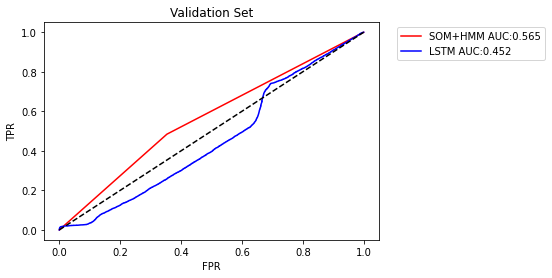

In [80]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr_valid_lstm, tpr_valid_lstm, t_valid_lstm = roc_curve(y_valid, y_valid_preds_lstm)
auc_valid_lstm = roc_auc_score(y_valid, y_valid_preds_lstm)

fpr_valid_shmm, tpr_valid_shmm, t_valid_shmm = roc_curve(y_valid, y_valid_preds_SHMM)
auc_valid_shmm = roc_auc_score(y_valid, y_valid_preds_SHMM)

plt.plot(fpr_valid_shmm, tpr_valid_shmm, 'r-', label = 'SOM+HMM AUC:%.3f'%auc_valid_shmm)
plt.plot(fpr_valid_lstm, tpr_valid_lstm, 'b-', label = 'LSTM AUC:%.3f'%auc_valid_lstm)

plt.plot([0,1],[0,1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(bbox_to_anchor = (1.04,1), loc = 'upper left')
plt.title('Validation Set')
plt.show()